A few references:

* [ARVIZ API](https://python.arviz.org/en/latest/api/index.html)
* [PYMC API](https://www.pymc.io/projects/docs/en/stable/api.html)
* [xarray API](https://docs.xarray.dev/en/stable/api.html)
* [daft](https://docs.daft-pgm.org/en/latest/): &nbsp; [daft & complete pooling](https://www.tensorflow.org/probability/examples/Multilevel_Modeling_Primer#41_complete_pooling_model)
* [graphviz](https://graphviz.readthedocs.io/en/stable/api.html): &nbsp; [pymc.model_to_graphviz](https://www.pymc.io/projects/docs/en/stable/api/generated/pymc.model_to_graphviz.html), <a href="https://www.pymc.io/projects/docs/en/stable/_modules/pymc/model_graph.html#:~:text=VarName%22%2C%20str)%0A%0A%0Aclass-,ModelGraph,-%3A%0A%20%20%20%20def%20__init__(self"> pymc.model_graph.ModelGraph</a>

<br>

# Preliminaries

In [1]:
!python --version

Python 3.8.13


<br>

## Environment

In [2]:
import os
import pathlib

<br>

Set path

In [3]:
os.chdir(path=str(pathlib.Path(os.getcwd()).parent))

In [4]:
os.getcwd()

'J:\\library\\plausibilities\\delineating'

<br>

## Libraries

In [5]:
%matplotlib inline

In [6]:
import logging
import collections

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

import numpy as np
import pandas as pd
import seaborn as sns

import arviz as az
import pymc as pm
import xarray as xr
import aesara.tensor as at
import graphviz

<br>

Versions

In [7]:
az.__version__

'0.13.0'

In [8]:
pm.__version__

'4.3.0'

In [9]:
np.__version__

'1.22.3'

<br>

## Custom

In [10]:
import src.graphics.settings
import src.graphics.sketch

<br>

Aesthetics

In [11]:
settings = src.graphics.settings.Settings()

settings.layout()
settings.aesthetics()

<br>

For diagrams/figures

In [12]:
sketch = src.graphics.sketch.Sketch()

In [13]:
Labels = collections.namedtuple(typename='Labels', field_names=['title', 'xlabel', 'ylabel'])

<br>

## Settings

Seed

In [14]:
RANDOM_SEED = 8924

<br>

Graphing

In [15]:
az.style.use('arviz-darkgrid')

<br>

## Logging

In [16]:
logging.basicConfig(level=logging.INFO, 
                    format='\n%(message)s\n%(asctime)s.%(msecs)03d\n', 
                    datefmt='%Y-%m-%d %H:%M:%S')
logger = logging.getLogger(__name__)

<br>
<br>

# Data

## Dwelling Level

In [17]:
try:
    data = pd.read_csv(filepath_or_buffer=pm.get_data('srrs2.dat'))
except FileNotFoundError as err:
    raise Exception(err.strerror)

In [18]:
data.columns

Index(['idnum', 'state', 'state2', 'stfips', 'zip', 'region', 'typebldg',
       'floor', 'room', 'basement', 'windoor', 'rep', 'stratum', 'wave',
       'starttm', 'stoptm', 'startdt', 'stopdt', 'activity', 'pcterr', 'adjwt',
       'dupflag', 'zipflag', 'cntyfips', 'county'],
      dtype='object')

In [19]:
data.rename(mapper=str.strip, axis='columns', inplace=True)

In [20]:
data.head()

,idnum,state,state2,stfips,zip,region,typebldg,floor,room,basement,...,stoptm,startdt,stopdt,activity,pcterr,adjwt,dupflag,zipflag,cntyfips,county
0,1,AZ,AZ,4,85920,1,1,1,2,N,...,1100,112987,120287,0.3,0.0,136.060971,0,0,1,APACHE
1,2,AZ,AZ,4,85920,1,0,9,0,,...,700,70788,71188,0.6,33.3,128.784975,0,0,1,APACHE
2,3,AZ,AZ,4,85924,1,1,1,3,N,...,1145,70788,70788,0.5,0.0,150.245112,0,0,1,APACHE
3,4,AZ,AZ,4,85925,1,1,1,3,N,...,1900,52088,52288,0.6,97.2,136.060971,0,0,1,APACHE
4,5,AZ,AZ,4,85932,1,1,1,1,N,...,900,70788,70788,0.3,0.0,136.060971,0,0,1,APACHE


<br>

Structuring; concatenating the `pure state` & `pure county` codes

* [FIPS States](https://en.wikipedia.org/wiki/Federal_Information_Processing_Standard_state_code)
* [FIPS Counties](https://en.wikipedia.org/wiki/List_of_United_States_FIPS_codes_by_county)


In [21]:
data.loc[:, 'fips'] = data.stfips.astype(str).str.zfill(2) + data.cntyfips.astype(str).str.zfill(3)
data.head()

,idnum,state,state2,stfips,zip,region,typebldg,floor,room,basement,...,startdt,stopdt,activity,pcterr,adjwt,dupflag,zipflag,cntyfips,county,fips
0,1,AZ,AZ,4,85920,1,1,1,2,N,...,112987,120287,0.3,0.0,136.060971,0,0,1,APACHE,04001
1,2,AZ,AZ,4,85920,1,0,9,0,,...,70788,71188,0.6,33.3,128.784975,0,0,1,APACHE,04001
2,3,AZ,AZ,4,85924,1,1,1,3,N,...,70788,70788,0.5,0.0,150.245112,0,0,1,APACHE,04001
3,4,AZ,AZ,4,85925,1,1,1,3,N,...,52088,52288,0.6,97.2,136.060971,0,0,1,APACHE,04001
4,5,AZ,AZ,4,85932,1,1,1,1,N,...,70788,70788,0.3,0.0,136.060971,0,0,1,APACHE,04001


<br>

## County Level

In [22]:
try:
    counties = pd.read_csv(filepath_or_buffer=pm.get_data('cty.dat'))
except FileNotFoundError as err:
    raise Exception(err.strerror)

In [23]:
counties.loc[:, 'fips'] = counties.stfips.astype(str).str.zfill(2) + counties.ctfips.astype(str).str.zfill(3)

<br>

## Excerpting & Merging

Excerpt: Focus on Minnesota, MN, dwellings.

In [24]:
excerpt = data.loc[data['state'] == 'MN', :]
excerpt.head()

,idnum,state,state2,stfips,zip,region,typebldg,floor,room,basement,...,startdt,stopdt,activity,pcterr,adjwt,dupflag,zipflag,cntyfips,county,fips
5080,5081,MN,MN,27,55735,5,1,1,3,N,...,12088,12288,2.2,9.7,1146.499190,1,0,1,AITKIN,27001
5081,5082,MN,MN,27,55748,5,1,0,4,Y,...,11888,12088,2.2,14.5,471.366223,0,0,1,AITKIN,27001
5082,5083,MN,MN,27,55748,5,1,0,4,Y,...,20288,21188,2.9,9.6,433.316718,0,0,1,AITKIN,27001
5083,5084,MN,MN,27,56469,5,1,0,4,Y,...,122987,123187,1.0,24.3,461.623670,0,0,1,AITKIN,27001
5084,5085,MN,MN,27,55011,3,1,0,4,Y,...,12888,13088,3.1,13.8,433.316718,0,0,3,ANOKA,27003


<br>

Merge dwelling & county level [uranium] data.

In [25]:
excerpt = excerpt.merge(counties[['fips', 'Uppm']], how='left', on='fips')
excerpt.columns

Index(['idnum', 'state', 'state2', 'stfips', 'zip', 'region', 'typebldg',
       'floor', 'room', 'basement', 'windoor', 'rep', 'stratum', 'wave',
       'starttm', 'stoptm', 'startdt', 'stopdt', 'activity', 'pcterr', 'adjwt',
       'dupflag', 'zipflag', 'cntyfips', 'county', 'fips', 'Uppm'],
      dtype='object')

In [26]:
excerpt.head()

,idnum,state,state2,stfips,zip,region,typebldg,floor,room,basement,...,stopdt,activity,pcterr,adjwt,dupflag,zipflag,cntyfips,county,fips,Uppm
0,5081,MN,MN,27,55735,5,1,1,3,N,...,12288,2.2,9.7,1146.499190,1,0,1,AITKIN,27001,0.502054
1,5082,MN,MN,27,55748,5,1,0,4,Y,...,12088,2.2,14.5,471.366223,0,0,1,AITKIN,27001,0.502054
2,5083,MN,MN,27,55748,5,1,0,4,Y,...,21188,2.9,9.6,433.316718,0,0,1,AITKIN,27001,0.502054
3,5084,MN,MN,27,56469,5,1,0,4,Y,...,123187,1.0,24.3,461.623670,0,0,1,AITKIN,27001,0.502054
4,5085,MN,MN,27,55011,3,1,0,4,Y,...,13088,3.1,13.8,433.316718,0,0,3,ANOKA,27003,0.428565


<br>

## Duplicates

In [27]:
logger.info(f'# of instances: {excerpt.shape}')
logger.info(f'# of unique instances: {excerpt.drop_duplicates().shape}')
logger.info(f"# of unique codes: {excerpt['idnum'].unique().shape}")


# of instances: (927, 27)
2022-11-17 13:47:26.630


# of unique instances: (919, 27)
2022-11-17 13:47:26.650


# of unique codes: (919,)
2022-11-17 13:47:26.653



<br>

Hence

In [28]:
excerpt.drop_duplicates(inplace=True)
excerpt['idnum'].unique().shape

(919,)

<br>
<br>

# Explore

In [29]:
excerpt.loc[:, 'ln_radon'] = np.log(excerpt['activity'] + 0.1)

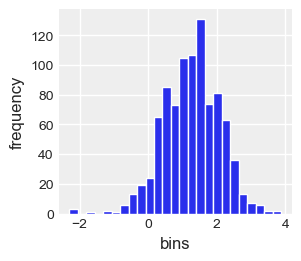

In [30]:
ax = sketch.figure(width=2.9, height=2.5)
ax.hist(excerpt.ln_radon, bins=25)
sketch.annotation(ax, Labels(title='', xlabel='bins', ylabel='frequency'))

<br>
<br>

# Model

## Simple

<br>

Snippets:

>  ```python
len(coords.get('Floors'))

> ```python 
with complete:
    logger.info(at.shape(epsilon).eval())
    
>```python
epsilon.eval()

<br>

Add more notes:

* A simple linear regression model: an intercept, a gradient whereby the accompanying independent variable is *dwelling level*
* The depedent variable is *ln(radon)*
* Is the *intercept* implicit below?

<br>

<br>

### Model

* `logger.info(level.get_value())`

In [31]:
coords = {'LevelName': ['Basement', 'Ground']}

In [32]:
with pm.Model(coords=coords) as complete:
    
    
    # the values of the <floor> field
    levelcode = pm.Data(name='levelcode', value=excerpt.floor.values, dims='N', mutable=True)
    logger.info(levelcode.get_value().shape)
    logger.info(levelcode.type())
    
    
    # <initial> probably has two elements - the object <Dwelling> has two elements, therefore two random values from a normal distribution
    initial = pm.Normal(name='initial', mu=0.0, sigma=10.0, dims='LevelName')
    
    
    # shape(mu) === shape(floor)
    mu = initial[levelcode]
    
    
    # model
    sigma = pm.Exponential(name='sigma', lam=1.0)
    y = pm.Normal('y', mu=mu, sigma=sigma, observed=excerpt['ln_radon'].to_numpy(), dims='N')
    


(919,)
2022-11-17 13:47:27.684


<TensorType(int32, (None,))>
2022-11-17 13:47:27.686



<br>
<br>

Is this the correct seeding method/approach?

In [33]:
complete.initial_point(seed=RANDOM_SEED)

{'initial': array([0., 0.]), 'sigma_log__': array(0.)}

In [34]:
initial.eval()

array([  5.16709158, -10.92063463])

<br>

Illustration of model

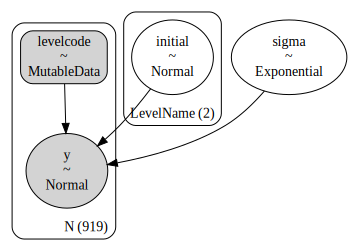

In [35]:
pm.model_to_graphviz(complete)

In [36]:
diagram = pm.model_graph.ModelGraph(model=complete).make_graph()
diagram.node_attr.update(shape='circle')
diagram.save(os.path.join(os.getcwd(), 'notebooks', 'simple.gv'))
graphviz.render(engine='dot', format='pdf', filepath=os.path.join(os.getcwd(), 'notebooks', 'simple.gv'));

In [37]:
type(diagram)

graphviz.dot.Digraph

<br>

### Prior Predictive Samples

An inspection of [prior predictive samples](https://www.pymc.io/projects/docs/en/stable/api/generated/pymc.sample_prior_predictive.html#pymc.sample_prior_predictive)

* `inferences.keys()`

* `inferences.get('prior').keys()`


In [38]:
with complete:
    inferences = pm.sample_prior_predictive()
    

Sampling: [initial, sigma, y]

Sampling: [initial, sigma, y]
2022-11-17 13:47:29.633



In [39]:
inferences

Inference data with groups:
	> prior
	> prior_predictive
	> observed_data
	> constant_data

<br>
<br>

**Alternative Graph**

* For the object's keys: 

>```python
prior.keys()

* Graphing:<br>[seaborn.boxplot](https://seaborn.pydata.org/generated/seaborn.boxplot.html)<br>[maxplotlib.axes.Axes.boxplot](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.boxplot.html#matplotlib.axes.Axes.boxplot)




The data

In [40]:
prior = inferences.get('prior')

levelname = prior.get('LevelName').values

indices = np.asarray((np.where(levelname == 'Basement'))).squeeze()
basement = pd.DataFrame(data = {'initial': prior.get('initial').values[0, :, indices], 'level': indices, 'type': prior.get('LevelName').values[indices]})

indices = np.asarray((np.where(levelname == 'Ground'))).squeeze()
ground = pd.DataFrame(data = {'initial': prior.get('initial').values[0, :, indices], 'level': indices, 'type': prior.get('LevelName').values[indices]})

readings = pd.concat([basement, ground], axis = 0, ignore_index=True)

logger.info(readings.shape)
logger.info(readings.head())



(1000, 3)
2022-11-17 13:47:29.907


     initial  level      type
0 -11.435528      0  Basement
1   6.746673      0  Basement
2  -2.111621      0  Basement
3  -7.460295      0  Basement
4 -10.209144      0  Basement
2022-11-17 13:47:29.909



<br>

An alternative graph

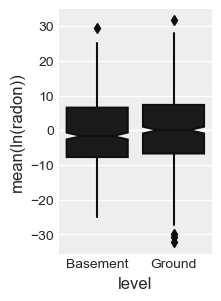

In [41]:
ax = sketch.figure(width=2.1, height=2.9)
sns.boxplot(data=readings, x='type', y='initial', notch=True, color='k', showcaps=False, ax=ax)
sketch.annotation(ax, Labels(title='', xlabel='level', ylabel='mean(ln(radon))'))

<br>

### Modelling

References:
* [pymc.sample](https://www.pymc.io/projects/docs/en/stable/api/generated/pymc.sample.html)

In [42]:
with complete:
    
    # starting of with the default sample settings
    trace = pm.sample(draws=1000, cores=None, tune=1000)

Auto-assigning NUTS sampler...

Auto-assigning NUTS sampler...
2022-11-17 13:47:31.411

Initializing NUTS using jitter+adapt_diag...

Initializing NUTS using jitter+adapt_diag...
2022-11-17 13:47:31.413

Multiprocess sampling (4 chains in 4 jobs)

Multiprocess sampling (4 chains in 4 jobs)
2022-11-17 13:47:35.233

NUTS: [initial, sigma]

NUTS: [initial, sigma]
2022-11-17 13:47:35.234



Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 31 seconds.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 31 seconds.
2022-11-17 13:48:06.939



<br>

Hence

In [43]:
logger.info(trace.keys())


KeysView(Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data
	> constant_data)
2022-11-17 13:48:12.982



<br>

`trace` will be thecore inference object, combining the `trace` & `inferences` objects $\longrightarrow$

In [44]:
trace.extend(inferences)
trace

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data

<br>

### Metrics, Measures, Traces

In [45]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
initial[Basement],1.362,0.028,1.308,1.415,0.000,0.000,7543.0,2997.0,1.0
initial[Ground],0.777,0.065,0.659,0.897,0.001,0.001,6057.0,3188.0,1.0
sigma,0.791,0.018,0.756,0.824,0.000,0.000,6857.0,3267.0,1.0


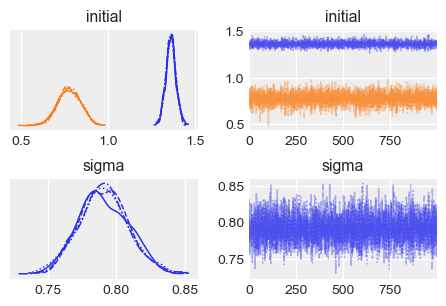

In [46]:
with complete:
    az.plot_trace(data=trace, figsize=(4.35, 2.95))

<br>

### Posterior Predictive Samples

In [47]:
with complete:
    ppc = pm.sample_posterior_predictive(trace)

Sampling: [y]

Sampling: [y]
2022-11-17 13:48:16.261



<br>

Hence, the resulting inferences

In [48]:
logger.info(ppc.keys())


KeysView(Inference data with groups:
	> posterior_predictive
	> observed_data
	> constant_data)
2022-11-17 13:48:17.038



<br>

Append the latest inference data to the core inference object, i.e., `trace`

In [49]:
trace.extend(ppc)
trace

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data

<br>

### High Density Interval

A helper function
* [About `arviz.hdi(.)`](https://arviz-devs.github.io/arviz/api/generated/arviz.hdi.html)

* [About `xarray.DataArray`](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.html#xarray.DataArray)

* [xarray.DataArray.groupy](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.groupby.html#xarray.DataArray.groupby)

* cf. `trace.constant_data['level']` & `trace.constant_data['N']`

<br>

In [50]:
az.hdi(trace.posterior_predictive['y'].groupby(group=trace.constant_data['levelcode']).var(), 
       input_core_dims=[['chain', 'draw']])

<xarray.Dataset>
Dimensions:    (levelcode: 2, hdi: 2)
Coordinates:
  * levelcode  (levelcode) int64 0 1
  * hdi        (hdi) <U6 'lower' 'higher'
Data variables:
    y          (levelcode, hdi) float64 0.5375 0.6992 0.472 0.7595

<br>

### Structuring

Labels

In [51]:
labels = trace.posterior['LevelName'][trace.constant_data['levelcode']]
labels

<xarray.DataArray 'LevelName' (N: 919)>
array(['Ground', 'Basement', 'Basement', ..., 'Basement', 'Basement',
       'Basement'], dtype='<U8')
Coordinates:
    LevelName  (N) <U8 'Ground' 'Basement' 'Basement' ... 'Basement' 'Basement'
  * N          (N) int32 0 1 2 3 4 5 6 7 8 ... 911 912 913 914 915 916 917 918

<br>

A preview

In [52]:
trace.observed_data

<xarray.Dataset>
Dimensions:  (N: 919)
Coordinates:
  * N        (N) int32 0 1 2 3 4 5 6 7 8 ... 910 911 912 913 914 915 916 917 918
Data variables:
    y        (N) float64 0.8329 0.8329 1.099 0.09531 ... 1.526 1.629 1.335 1.099
Attributes:
    created_at:                 2022-11-17T13:48:07.786227
    arviz_version:              0.13.0
    inference_library:          pymc
    inference_library_version:  4.3.0

<br>

Co$\ddot{o}$rdinates

* [xarray API](https://docs.xarray.dev/en/stable/api.html)

* [xarray.Dataset.assign_coords](https://docs.xarray.dev/en/stable/generated/xarray.Dataset.assign_coords.html#xarray.Dataset.assign_coords)



In [53]:
trace.observed_data.assign_coords(LevelName=labels)

<xarray.Dataset>
Dimensions:    (N: 919)
Coordinates:
  * N          (N) int32 0 1 2 3 4 5 6 7 8 ... 911 912 913 914 915 916 917 918
    LevelName  (N) <U8 'Ground' 'Basement' 'Basement' ... 'Basement' 'Basement'
Data variables:
    y          (N) float64 0.8329 0.8329 1.099 0.09531 ... 1.629 1.335 1.099
Attributes:
    created_at:                 2022-11-17T13:48:07.786227
    arviz_version:              0.13.0
    inference_library:          pymc
    inference_library_version:  4.3.0

<br>

### Graphs

In [54]:
averages = trace.posterior.mean(dim=('chain', 'draw'))
averages

<xarray.Dataset>
Dimensions:    (LevelName: 2)
Coordinates:
  * LevelName  (LevelName) <U8 'Basement' 'Ground'
Data variables:
    initial    (LevelName) float64 1.362 0.7768
    sigma      float64 0.7907